# Coursera - Finite-difference method - Acoustic Waves 2D - Homogeneous case

## Importing libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define parameters
x_n_points = 500            # Number of points along X
z_n_points = x_n_points     # Equal number of points along Z
dx = 1                      # Grid length along X, m
dz = dx                     # Square sized grids
c_0 = 580                   # Wave velocity in the medium, m/s

source_x = 250              # Location of source, m
source_z = source_x
receiver_x = 330            # Location of receiver, m
receiver_z = source_z

t_n_points = 502            # Time steps, sec
dt = 0.001                  # Time interval, sec

f_0 = 40                   # Dominant frequency, Hz
t_0 = 4/float(f_0)          # Source time shift

print ("CFL stability criteria (epsilon = c0*(dt/dx)): ", c_0*dt/float(dx))     # CFL stability criteria
p_cur = np.zeros((x_n_points, z_n_points))           # Pressure at time n
p_next = np.zeros((x_n_points, z_n_points))          # Pressure at time n+1
p_prev = np.zeros((x_n_points, z_n_points))          # Pressure at time n-1
d2p_x = np.zeros((x_n_points, z_n_points))           # 2nd derivative pressure along X
d2p_z = np.zeros((x_n_points, z_n_points))           # 2nd derivative pressure along Z

c = np.zeros((x_n_points, z_n_points))               # Define wave velocity in the medium
c = c + c_0                                          # Assuming homogeneous medium - constant wave velocity

x = np.arange(x_n_points)  # Defining the co-ordinates
x = x * dx
z = np.arange(z_n_points)  # Defining the co-ordinates
z = z * dz

seis = np.zeros(t_n_points)                         # Empty seismogram

CFL stability criteria (epsilon = c0*(dt/dx)):  0.58


## Plotting source-time function and fourier transform

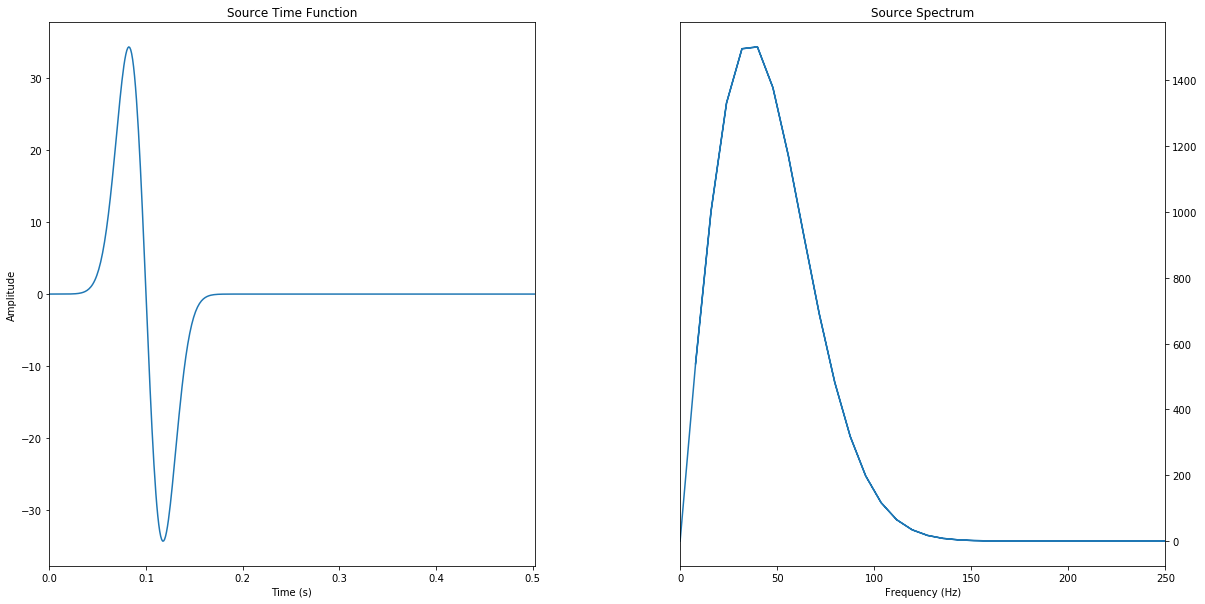

In [2]:
source_t = np.zeros(t_n_points + 1)                     # Defining source time function (Gaussian)
time = np.linspace(0, dt*t_n_points, t_n_points)
source_t = -2 * (time - t_0) * (f_0 ** 2) * (np.exp(-1.0 * (f_0 ** 2) * (time - t_0) ** 2))

# plt.ion()
fig1 = plt.figure(figsize = (20,10))
gs1 = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot Source Time Function
ax1 = plt.subplot(gs1[0])
ax1.plot(time, source_t)                            # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot Fourier transform
ax2 = plt.subplot(gs1[1])
spec = np.fft.fft(source_t)                          # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / float(4))        # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec))                 # plot frequency and amplitude
ax2.set_xlim(0, 250)                                 # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()


## Plotting analytical and numerical solutions

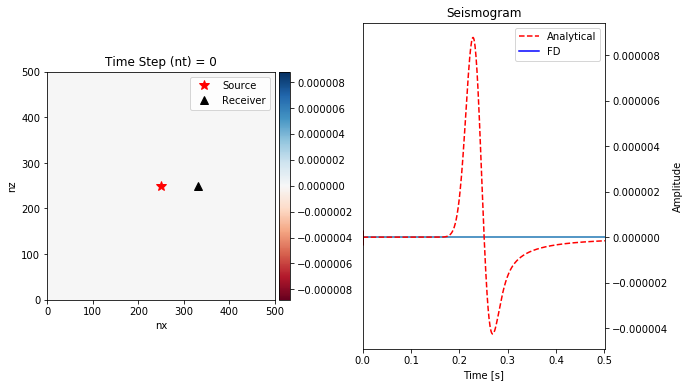

<Figure size 432x288 with 0 Axes>

In [3]:
# Analytical Solution
G = np.zeros(t_n_points)
r = np.sqrt((source_x - receiver_x)**2 + (source_z - receiver_z)**2)
for i_t in range(0, t_n_points):
    if (time[i_t] - np.abs(x[receiver_x] - x[source_x]) / float(c_0)) >= 0:
        G[i_t] = (1/float((2 * np.pi * c_0 ** 2)))*(1/float(np.sqrt((time[i_t] ** 2) - (r ** 2 / (c_0 ** 2)))))
Gc = np.convolve(G, source_t * dt)
Gc = Gc[0:t_n_points]
lim = Gc.max()  # get limit value from maximum amplitude of analytical solution

# Plot 2D Wave Propagation
plt.ion()
fig2 = plt.figure(figsize=(10, 6))
gs2 = gridspec.GridSpec(1,2,width_ratios=[1,1],hspace=0.3, wspace=0.3)
ax3 = plt.subplot(gs2[0])
leg1, = ax3.plot(source_x, source_z, 'r*', markersize=11)     # plot position of the source in model
leg2, = ax3.plot(receiver_x, receiver_z, 'k^', markersize=8)  # plot position of the receiver in model
im3 = ax3.imshow(p_cur, vmin=-1*lim, vmax=+1*lim, interpolation="nearest", cmap=plt.cm.RdBu)
div = make_axes_locatable(ax3)
cax = div.append_axes("right", size="5%", pad=0.05)           # size & position of colorbar
fig2.colorbar(im3, cax=cax)                                   # plot colorbar
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlim(0, x_n_points)
ax3.set_ylim(0, z_n_points)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot Seismogram
ax4 = plt.subplot(gs2[1])
up41, = ax4.plot(time, seis)                                    # update seismogram each time step
up42, = ax4.plot([0], [0], 'r|', markersize=15)                 # update time step position
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
leg3, = ax4.plot(0,0,'r--',markersize=1)
leg4, = ax4.plot(0,0,'b-',markersize=1)
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.plot(time, Gc, 'r--')
plt.show()

# Numerical Solution - Finite Difference Method
for i_t in range(0, t_n_points):
    for i in range(0, x_n_points - 1):
        d2p_x[i, :] = (p_cur[i - 1, :] - 2 * p_cur[i, :] + p_cur[i + 1, :]) / float(dx ** 2)
    for j in range(0, z_n_points - 1):
        d2p_z[:, j] = (p_cur[:, j - 1] - 2 * p_cur[:, j] + p_cur[:, j + 1]) / float(dz ** 2)

    # Pressure at next time point
    p_next = 2 * p_cur - p_prev + (c ** 2) * (dt ** 2) * (d2p_z + d2p_x)
    p_next[source_x, source_z] = p_next[source_x, source_z] + source_t[i_t]/float((dx * dz) * (dt ** 2))
    p_prev, p_cur = p_cur, p_next                                 # Remapping time intervals
    seis[i_t] = p_cur[receiver_x, receiver_z]                     # Reading pressure at the receiver

    # Update data of the wave propagation
    idisp = 5  # display frequency
    if (i_t % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % i_t)
        ax3.imshow(p_cur, vmin=-1*lim, vmax=+1*lim, interpolation="nearest", cmap=plt.cm.RdBu)
        up41.set_ydata(seis)
        up42.set_data(time[i_t], seis[i_t])
        plt.gcf().canvas.draw()